In [ ]:
#@title Set Seeds
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Person to exclude during training
excluded_person = "bell"

In [ ]:
#@title Load Embeddings
import numpy as np
import gc
import torch
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

vis_path = f'/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/Finetuned_no_{excluded_person}_patches.npy'
txt_path = '/content/drive/MyDrive/TESI/CODICE/CLIP_Embeddings/ResNet_long_captions_emb.npy'

vis_dict = np.load(vis_path, allow_pickle=True).item()
text_dict = np.load(txt_path, allow_pickle=True).item()

keys_vis = sorted(list(vis_dict.keys()))
keys_txt = sorted(list(text_dict.keys()))
assert keys_vis == keys_txt, "Keys do not match"

# extract Visual (embedding, label) of chosen people
# MAKE SURE THAT THE EMBEDDINGS WITH THE SAME KEY ARE EXTRACTED IN THE SAME ORDER FROM VIS_EMB & TEXT_EMB
vis_emb_list = []
txt_emb_list = []
label_list = []

for k in keys_vis:
  if vis_dict[k][0] != excluded_person:
    embedding = vis_dict[k][2].view(10, -1)[-1] # take the full image embedding
    vis_emb_list.append(embedding)
    label_list.append(vis_dict[k][1])
    txt_emb_list.append(text_dict[k][2].squeeze(0).clone().detach())

# ------- TRAIN TEST SPLIT ---------
data = list(zip(vis_emb_list, label_list, txt_emb_list))

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# back into individual lists
train_vis_emb_list, train_label_list, train_txt_emb_list = zip(*train_data)
val_vis_emb_list, val_label_list, val_txt_emb_list = zip(*val_data)
# ----------------------------------

train_vis_emb_tensor = torch.stack(train_vis_emb_list).float()
train_txt_emb_tensor = torch.stack(train_txt_emb_list).float()
train_label_tensor = torch.stack([torch.tensor(label) for label in train_label_list]).float()

val_vis_emb_tensor = torch.stack(val_vis_emb_list).float()
val_txt_emb_tensor = torch.stack(val_txt_emb_list).float()
val_label_tensor = torch.stack([torch.tensor(label) for label in val_label_list]).float()

print(f"train_vis_emb: {train_vis_emb_tensor.size()}   \t val_vis_emb: {val_vis_emb_tensor.size()}")
print(f"train_text_emb: {train_txt_emb_tensor.size()}  \t val_text_emb: {val_txt_emb_tensor.size()}")
print(f"train_labels: {train_label_tensor.size()} \t\t val_labels: {val_label_tensor.size()}")

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_label_list), y=train_label_list)
class_weights = torch.tensor(class_weights).float().to(device)
print(f"Class weights: {class_weights}")

train_vis_emb: torch.Size([7984, 512])   	 val_vis_emb: torch.Size([1997, 512])
train_text_emb: torch.Size([7984, 512])  	 val_text_emb: torch.Size([1997, 512])
train_labels: torch.Size([7984]) 		 val_labels: torch.Size([1997])
Class weights: tensor([0.7922, 1.3555], device='cuda:0')


In [ ]:
#@title CustomDataset
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, vis_emb_tensor, txt_emb_tensor, vis_label_tensor):
        self.vis_emb_tensor = vis_emb_tensor
        self.txt_emb_tensor = txt_emb_tensor
        self.vis_label_tensor = vis_label_tensor

    def __len__(self):
        return self.vis_emb_tensor.shape[0]

    def __getitem__(self, idx):
        return self.vis_emb_tensor[idx], self.txt_emb_tensor[idx], self.vis_label_tensor[idx]

In [ ]:
#@title Fusion MLP Architecture
import torch
import torch.nn as nn

class Fusion_MLP(nn.Module):
    def __init__(self):
        super(Fusion_MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, visual_emb, text_emb):

        x = torch.cat([visual_emb, text_emb], dim=1)

        return self.layers(x)

In [ ]:
#@title Training Function
from sklearn.metrics import precision_score, recall_score, f1_score

def CustomTraining(wandb_flag, batch_size, epochs, learning_rate, weight_decay):
  set_seed(0)

  model = Fusion_MLP().to(device)
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'Number of trainable parameters: {trainable_params}')

  # Create datasets
  train_dataset = CustomDataset(train_vis_emb_tensor, train_txt_emb_tensor, train_label_tensor)
  val_dataset = CustomDataset(val_vis_emb_tensor, val_txt_emb_tensor, val_label_tensor)

  # Create dataloaders
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
  loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

  # Auto updates the LR if there is no improvement on the val_loss
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

  for epoch in range(epochs):
      # TRAINING
      model.train()

      correct_predictions = 0
      total_predictions = 0
      total_loss = 0

      for i, (vis_emb, txt_emb, labels) in enumerate(train_dataloader):
          vis_emb = vis_emb.to(device)
          txt_emb = txt_emb.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(vis_emb, txt_emb).squeeze()
          loss = loss_fn(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          probabilities = torch.sigmoid(outputs)
          predictions = (probabilities > 0.5).float()
          correct_predictions += (predictions == labels).sum().item()
          total_predictions += labels.size(0)
          total_loss += loss.item()

      # calculate and print average train metrics for the epoch...
      train_accuracy = correct_predictions / total_predictions
      train_loss = total_loss / len(train_dataloader)

      # VALIDATION
      model.eval()

      correct_predictions = 0
      total_predictions = 0
      total_loss = 0
      all_predictions = []
      all_labels = []

      with torch.no_grad():
        for i, (vis_emb, txt_emb, labels) in enumerate(val_dataloader):
            vis_emb = vis_emb.to(device)
            txt_emb = txt_emb.to(device)
            labels = labels.to(device)

            outputs = model(vis_emb, txt_emb).squeeze()
            loss = loss_fn(outputs, labels)

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            total_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

      # calculate and print average validation metrics for the epoch...
      val_accuracy = correct_predictions / total_predictions
      val_loss = total_loss / len(val_dataloader)

      all_predictions = np.concatenate(all_predictions)
      all_labels = np.concatenate(all_labels)
      f1_macro = f1_score(all_labels, all_predictions, average='macro') # Better For UNBALANCED data
      f1_weight = f1_score(all_labels, all_predictions, average='weighted')

      #scheduler.step(val_loss)
      # free memory after each epoch
      torch.cuda.empty_cache()

      if wandb_flag:
        wandb.log({"Training Loss": train_loss, "Training Accuracy": train_accuracy,
                  "Validation Loss": val_loss, "Validation Accuracy": val_accuracy,
                    "Val F1-Macro Score": f1_macro}
                  )

  if wandb_flag: wandb.finish()
  return model, f1_macro, f1_weight

In [ ]:
#@title RANDOM SEARCH
from sklearn.model_selection import ParameterSampler
import numpy as np

# 17 min per search
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [80],
}

# Create the parameter grid
n_iter_search = 12  # Number of parameter settings that are sampled.
random_search = ParameterSampler(param_grid, n_iter=n_iter_search, random_state=0)

best_macro = 0
best_weighted = 0
best_macro_params = None
best_weight_params = None

for num, params in enumerate(random_search):
  print(f"--- {num} ---")
  model, macro, weighted  = CustomTraining(False, **params)
  if macro > best_macro:
      best_macro = macro
      best_macro_params = params
      print(f"Found new best F1 MACRO: {macro} \t {params}")
  if weighted > best_weighted:
      best_weighted = weighted
      best_weight_params = params
      print(f"Found new best F1 WEIGHTED: {weighted} \t {params}")

print(f'\nbest F1 WEIGHTED: {best_weighted} with parameters: {best_weight_params}')
print(f'Found new best F1 MACRO: {best_macro} with parameters: {best_macro_params}')

In [ ]:
# Re-train using best parameters found during Random Search
model, macro, weighted = CustomTraining(False, **best_macro_params)

Number of trainable parameters: 1709569


##TESTING

In [ ]:
#@title Get TEST Data

vis_dict = np.load(vis_path, allow_pickle=True).item()
text_dict = np.load(txt_path, allow_pickle=True).item()

vis_emb_list = []
txt_emb_list = []
label_list = []
original_frames_list = []

for k in keys_vis:
  if vis_dict[k][0] == excluded_person:
    embedding = vis_dict[k][2].view(10, -1)[-1] # take the full image embedding
    vis_emb_list.append(embedding)
    label_list.append(vis_dict[k][1])
    txt_emb_list.append(text_dict[k][2].squeeze(0).clone().detach())
    original_frames_list.append(text_dict[k][3]) # <------------------------ ASSICURO CHE CI SIANO GLI ORIGINAL FRAMES DENTRO!

test_vis_emb_tensor = torch.stack(vis_emb_list).float()
test_txt_emb_tensor = torch.stack(txt_emb_list).float()
test_label_tensor = torch.stack([torch.tensor(label) for label in label_list]).float()

print(f"--- TEST SPEAKER : {excluded_person.upper()} ---")
print(f"test_vis_emb: \t{test_vis_emb_tensor.size()}")
print(f"test_text_emb: \t{test_txt_emb_tensor.size()}")
print(f"test_labels: \t{test_label_tensor.size()}")
print(f"original_frames: {len(original_frames_list)}")

--- TEST SPEAKER : BELL ---
test_vis_emb: 	torch.Size([3751, 512])
test_text_emb: 	torch.Size([3751, 512])
test_labels: 	torch.Size([3751])
original_frames: 3751


In [ ]:
#@title Custom Test Dataset
from torch.utils.data import Dataset, DataLoader

class CustomTestDataset(Dataset):
    def __init__(self, vis_emb_tensor, txt_emb_tensor, vis_label_tensor, original_frames):
        self.vis_emb_tensor = vis_emb_tensor
        self.txt_emb_tensor = txt_emb_tensor
        self.vis_label_tensor = vis_label_tensor
        self.original_frames = original_frames

    def __len__(self):
        return self.vis_emb_tensor.shape[0]

    def __getitem__(self, idx):
        return self.vis_emb_tensor[idx], self.txt_emb_tensor[idx], self.vis_label_tensor[idx], self.original_frames[idx]

In [ ]:
#@title Test Code
from sklearn.metrics import accuracy_score, f1_score

criterion = torch.nn.BCEWithLogitsLoss()

test_dataset = CustomTestDataset(test_vis_emb_tensor, test_txt_emb_tensor, test_label_tensor, original_frames_list)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()

with torch.no_grad():
    test_loss_total = 0
    batch_number = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    for i, (vis_emb, txt_emb, labels, original_frames) in enumerate(test_dataloader):
        vis_emb = vis_emb.to(device)
        txt_emb = txt_emb.to(device)
        labels = labels.to(device)

        outputs = model(vis_emb, txt_emb).squeeze()
        test_loss = criterion(outputs, labels.float())
        test_loss_total += test_loss.item()
        batch_number += 1

        outputs_prob = torch.sigmoid(outputs)
        predictions = (outputs_prob > 0.5).float().cpu()  # predictions for each batch
        # Repeat each prediction by the number of associated frames
        repeated_predictions = torch.repeat_interleave(predictions, original_frames)
        all_predictions.append(repeated_predictions.numpy())

        repeated_labels = torch.repeat_interleave(labels.cpu(), original_frames)
        all_labels.append(repeated_labels.numpy())

    # lists of lists --> lists of numbers
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    test_loss = test_loss_total / batch_number
    accuracy = accuracy_score(all_labels, all_predictions)
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
    f1_macro = f1_score(all_labels, all_predictions, average='macro')

print("Test loss: ", round(test_loss,4))
print("Test Accuracy: ", round(accuracy,4))
print("F1 Weighted: ", round(f1_weighted,4))
print("F1 Macro: ", round(f1_macro,4))

Test loss:  0.9669
Test Accuracy:  0.7515
F1 Weighted:  0.7375
F1 Macro:  0.7391


In [ ]:
# INITIALIZE FINAL MATRIX
#final_cm = np.zeros((2, 2), dtype=int)

LONG


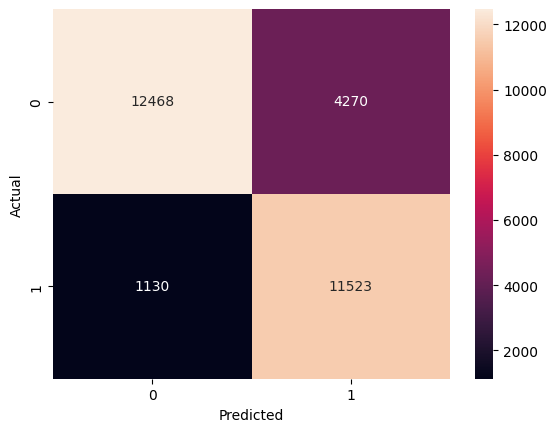

In [ ]:
#@title CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert all_predictions and all_labels to numpy arrays if they aren't already
all_predictions_np = np.array(all_predictions)
all_labels_np = np.array(all_labels)

# Calculate the confusion matrix
cm = confusion_matrix(all_labels_np, all_predictions_np)

#Assuming cm is your confusion matrix
print(excluded_person.upper())
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

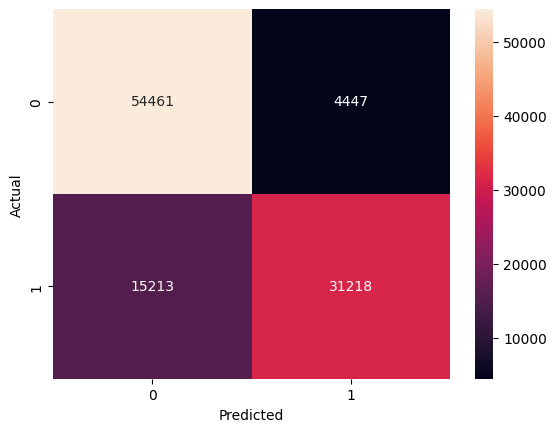

In [ ]:
#@title UPDATE FINAL MATRIX
final_cm+=cm
sns.heatmap(final_cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()